In [46]:
from scipy import signal
from scipy.signal import convolve2d
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.lib.function_base import histogram
from skimage.draw import line
import math

In [2]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.imread('../datas/f2.jpg',0)

In [36]:
def motion_blur(src,distance,direction=1):
    srcf = src.astype(np.float32)
    dst = np.zeros_like(srcf)
    kernel = np.zeros((distance,distance))
    if direction == 1:
        kernel[distance // 2,:] = 1 / distance
    else:
        kernel[:,distance // 2] = 1 / distance
    if len(src.shape) > 2:
        dst[:,:,0] = signal.convolve2d(srcf[:,:,0],kernel, mode='same', boundary='wrap')
        dst[:,:,1] = signal.convolve2d(srcf[:,:,1],kernel, mode='same', boundary='wrap')
        dst[:,:,2] = signal.convolve2d(srcf[:,:,2],kernel, mode='same', boundary='wrap')
    else:
        dst = signal.convolve2d(srcf,kernel, mode='same', boundary='wrap')
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    return dst.astype(np.uint8),kernel

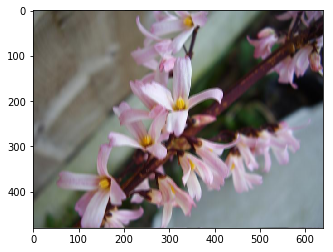

In [38]:
dst,kernel = motion_blur(src,7,2)
plt.imshow(dst)

In [40]:
class LineDictionary:
    def __init__(self):
        self.lines = {}
        self.Create3x3Lines()
        self.Create5x5Lines()
        self.Create7x7Lines()
        self.Create9x9Lines()
        return
    
    def Create3x3Lines(self):
        lines = {}
        lines[0] = [1,0,1,2]
        lines[45] = [2,0,0,2]
        lines[90] = [0,1,2,1]
        lines[135] = [0,0,2,2]
        self.lines[3] = lines
        return
    
    def Create5x5Lines(self):
        lines = {}        
        lines[0] = [2,0,2,4]
        lines[22.5] = [3,0,1,4]
        lines[45] = [0,4,4,0]
        lines[67.5] = [0,3,4,1]
        lines[90] = [0,2,4,2]
        lines[112.5] = [0,1,4,3]
        lines[135] = [0,0,4,4]
        lines[157.5]= [1,0,3,4]
        self.lines[5] = lines
        return
        
    def Create7x7Lines(self):
        lines = {}
        lines[0] = [3,0,3,6]
        lines[15] = [4,0,2,6]
        lines[30] = [5,0,1,6]
        lines[45] = [6,0,0,6]
        lines[60] = [6,1,0,5]
        lines[75] = [6,2,0,4]
        lines[90] = [0,3,6,3]
        lines[105] = [0,2,6,4]
        lines[120] = [0,1,6,5]
        lines[135] = [0,0,6,6]
        lines[150] = [1,0,5,6]
        lines[165] = [2,0,4,6]
        self.lines[7] = lines 
        return
    
    def Create9x9Lines(self):
        lines = {}
        lines[0] = [4,0,4,8]
        lines[11.25] = [5,0,3,8]
        lines[22.5] = [6,0,2,8]
        lines[33.75] = [7,0,1,8]
        lines[45] = [8,0,0,8]
        lines[56.25] = [8,1,0,7]
        lines[67.5] = [8,2,0,6]
        lines[78.75] = [8,3,0,5]
        lines[90] = [8,4,0,4]
        lines[101.25] = [0,3,8,5]
        lines[112.5] = [0,2,8,6]
        lines[123.75] = [0,1,8,7]
        lines[135] = [0,0,8,8]
        lines[146.25] = [1,0,7,8]
        lines[157.5] = [2,0,6,8]
        lines[168.75] = [3,0,5,8]
        self.lines[9] = lines
        return

In [44]:
lineLengths =[3,5,7,9]
lineTypes = ["full", "right", "left"]
lineDict = LineDictionary()
def LinearMotionBlur(img, dim, angle, linetype):
#     imgarray = np.array(img, dtype="float32")
    kernel = LineKernel(dim, angle, linetype)
    convolved = convolve2d(img, kernel, mode='same', fillvalue=255.0).astype("uint8")
    return convolved

def LineKernel(dim, angle, linetype):
    kernelwidth = dim
    kernelCenter = int(math.floor(dim/2))
    angle = SanitizeAngleValue(kernelCenter, angle)
    kernel = np.zeros((kernelwidth, kernelwidth), dtype=np.float32)
    lineAnchors = lineDict.lines[dim][angle]
    if(linetype == 'right'):
        lineAnchors[0] = kernelCenter
        lineAnchors[1] = kernelCenter
    if(linetype == 'left'):
        lineAnchors[2] = kernelCenter
        lineAnchors[3] = kernelCenter
    rr,cc = line(lineAnchors[0], lineAnchors[1], lineAnchors[2], lineAnchors[3])
    kernel[rr,cc]=1
    normalizationFactor = np.count_nonzero(kernel)
    kernel = kernel / normalizationFactor        
    return kernel

def SanitizeAngleValue(kernelCenter, angle):
    numDistinctLines = kernelCenter * 4
    angle = math.fmod(angle, 180.0)
    validLineAngles = np.linspace(0,180, numDistinctLines, endpoint = False)
    angle = nearestValue(angle, validLineAngles)
    return angle

def nearestValue(theta, validAngles):
    idx = (np.abs(validAngles-theta)).argmin()
    return validAngles[idx]

def randomAngle(kerneldim):
    kernelCenter = int(math.floor(kerneldim/2))
    numDistinctLines = kernelCenter * 4
    validLineAngles = np.linspace(0,180, numDistinctLines, endpoint = False)
    angleIdx = np.random.randint(0, len(validLineAngles))
    return int(validLineAngles[angleIdx])

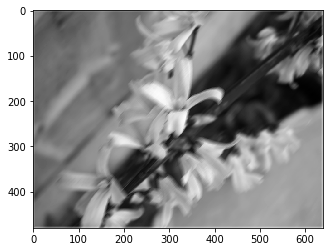

In [51]:
dst = LinearMotionBlur(gray,9,45,'full')
plt.imshow(dst,'gray')

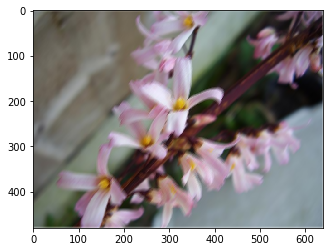

In [54]:
dstr = LinearMotionBlur(src[:,:,0],9,60,'full')
dstg = LinearMotionBlur(src[:,:,1],9,60,'full')
dstb = LinearMotionBlur(src[:,:,2],9,60,'full')
dst = cv2.merge([dstr,dstg,dstb])
plt.imshow(dst)